Getting the data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "..\\medical_insurance.csv"

df = pd.read_csv(file_path)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


Problem statement: multivariate logistic regression

Data Exploration

In [8]:
# look for nulls
null_mask = df.isnull().any(axis=1)
nan_mask = df.isna().any(axis=1)

null_rows = df[null_mask]
nan_rows = df[nan_mask]

print(null_rows, nan_rows)

# get info on df
print(df.info())

# look at age metrics
def _range(series):
 return series.max() - series.min()

print(
    df[["age"]].agg(["min", "max", "mean", "std", _range])
)


Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: [] Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB
None
              age
min     18.000000
max     64.000000
mean    39.109668
std     14.081459
_range  46.000000


Data preprocessing

In [9]:
import sklearn.model_selection
from sklearn import preprocessing

# normalize features and label
df[["age_norm", "bmi_norm", "children_norm"]] = preprocessing.MinMaxScaler().fit_transform(df[["age", "bmi", "children"]])
df[["sex_norm", "smoker_norm"]] = preprocessing.OrdinalEncoder().fit_transform(df[["sex", "smoker"]])

feature_cols = ["age_norm", "bmi_norm", "children_norm", "sex_norm"]
x = df[feature_cols].to_numpy()
y = df["smoker_norm"].to_numpy()

# train-test split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.3, random_state=42)
x_train, y_train

(array([[0.2826087 , 0.49582997, 0.6       , 1.        ],
        [0.80434783, 0.47282755, 0.4       , 0.        ],
        [0.19565217, 0.24791499, 0.        , 0.        ],
        ...,
        [0.45652174, 0.21280603, 1.        , 0.        ],
        [0.86956522, 0.24791499, 0.        , 1.        ],
        [0.41304348, 0.85122411, 0.4       , 0.        ]]),
 array([1., 0., 0., ..., 0., 0., 1.]))

Model creation and training

0.5678764422374762


c:\ProgramData\anaconda3\envs\learn\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\ProgramData\anaconda3\envs\learn\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


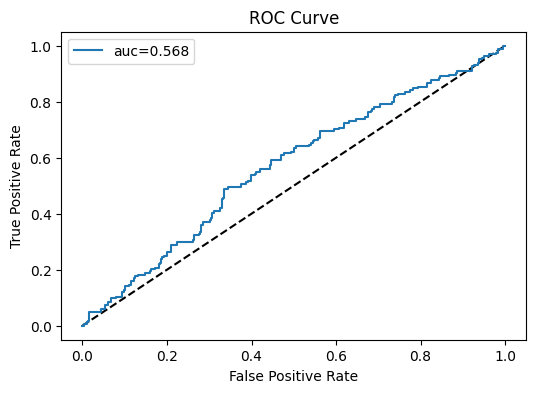

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_curve, roc_auc_score
import mlflow
import mlflow.sklearn
from datetime import datetime

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    accuracy = accuracy_score(actual, pred)
    return rmse, mae, r2, accuracy

with mlflow.start_run():
    model = LogisticRegression(random_state=16)

    model.fit(x_train, y_train)

    predicted = model.predict(x_test)

    (rmse, mae, r2, accuracy) = eval_metrics(y_test, predicted)

    # plot roc curve
    predicted_proba = model.predict_proba(x_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test, predicted_proba)
    auc = roc_auc_score(y_test, predicted_proba)

    fig = plt.figure(figsize=(6, 4))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="auc=" + str(round(auc, 3)))
    plt.legend(loc="best")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.savefig("ROC-Curve.png")
    print(auc)

    now = datetime.now()
    current_time = now.strftime("%Y_%m_%d_%H_%M_%S")

    model_name = "logictic_model_" + current_time

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_artifact("ROC-Curve.png")
    mlflow.sklearn.log_model(model, model_name)
    mlflow.sklearn.save_model(model, model_name)



0.5678764422374762


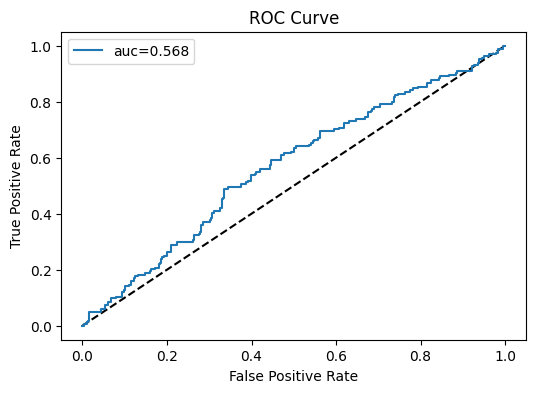

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
predicted_proba = model.predict_proba(x_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, predicted_proba)
auc = roc_auc_score(y_test, predicted_proba)

fig = plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="auc=" + str(round(auc, 3)))
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
print(auc)


K-fold cross-validation

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

cv = KFold(n_splits=10, random_state=1, shuffle=True)

model = LogisticRegression()

scores = cross_val_score(model, x, y, scoring="accuracy", cv=cv, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Accuracy: 0.797 (0.035)


In [17]:
# not gonna do LOOCV